<a href="https://colab.research.google.com/github/brenoslivio/MDNE_2024/blob/main/MDNE_2024/Project_2/Projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SCC5920 - Mineração de Dados Não Estruturados (2024)

**Projeto 2: Mineração de Imagens - Classificação de Abelhas e Vespas**

Prof. Ricardo Marcacini

**Aluno:** Breno Livio Silva de Almeida

**NUSP:** 10276675

---

In [3]:
!git clone https://github.com/brenoslivio/MDNE_2024.git

fatal: destination path 'MDNE_2024' already exists and is not an empty directory.


In [7]:
!pip install mahotas
!pip install optuna
import mahotas as mt
import polars as pl
import cv2
import cv2 as cv
import numpy as np
import os
import glob
import optuna
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, matthews_corrcoef, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_predict

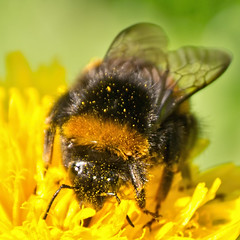

In [2]:
dataset_path = "MDNE_2024/Project_2/dataset"

df_bees = pl.read_csv(os.path.join(dataset_path, "labels.csv")).filter((pl.col("label") == "bee") | (pl.col("label") == "wasp") & (pl.col("photo_quality") == 1))

df_train = df_bees.filter((pl.col("is_validation") == 0) & (pl.col("is_final_validation") == 0))
df_test = df_bees.filter((pl.col("is_validation") == 1) & (pl.col("is_final_validation") == 0))
df_val = df_bees.filter((pl.col("is_validation") == 0) & (pl.col("is_final_validation") == 1))

image = io.imread(os.path.join(dataset_path, df_train["path"].sample(1).item().replace("\\", "/")))
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [20]:
df_train["label"].value_counts()

label,count
str,u32
"""bee""",2195
"""wasp""",1486


In [19]:
df_test["label"].value_counts()

label,count
str,u32
"""bee""",484
"""wasp""",313


In [18]:
df_val["label"].value_counts()

label,count
str,u32
"""wasp""",328
"""bee""",504


In [11]:
df_train["path"].sample(1).item()

'wasp1\\25745082194_361dcf22bd_n.jpg'

In [3]:
def extract_features(img_path):
  image = io.imread(os.path.join(dataset_path, img_path.replace("\\", "/")))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  textures = mt.features.haralick(image)
  features = {}

  ht_mean = textures.mean(axis=0)

  for i, feature in enumerate(mt.features.texture.haralick_labels[:-1]):
    features[feature] = ht_mean[i]

  return features

df_train_haralick = df_train.with_columns(pl.col("path").map_elements(lambda x: extract_features(x)).alias("features")).unnest("features").drop_nulls()
df_train_haralick

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,Angular Second Moment,Contrast,Correlation,Sum of Squares: Variance,Inverse Difference Moment,Sum Average,Sum Variance,Sum Entropy,Entropy,Difference Variance,Difference Entropy,Information Measure of Correlation 1,Information Measure of Correlation 2
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""bee1\10007154554_026417cfd0_n.…",1,0,0,0,1,0,0,"""bee""",0.008061,3948.304822,0.653884,5909.264871,0.171371,208.881818,19688.754663,8.40521,13.224486,0.000146,6.025976,-0.22159,0.94823
5,"""bee1\10128235063_dca17db76c_n.…",1,0,0,0,1,0,0,"""bee""",0.000122,3777.430951,0.560447,4354.136061,0.100561,246.535115,13639.113294,8.76776,14.289513,0.00014,6.085442,-0.185808,0.896628
6,"""bee1\10130729734_f68738333e_w.…",1,0,0,0,1,0,0,"""bee""",0.000803,1168.905381,0.855969,4128.8372,0.262922,292.066784,15346.443418,8.589249,12.65934,0.00032,4.922086,-0.32292,0.991448
7,"""bee1\10166485783_9cd6706c72_n.…",1,0,0,0,1,0,0,"""bee""",0.001138,910.963828,0.492477,932.590832,0.206791,248.978818,2819.399501,7.651895,11.669624,0.000458,4.760354,-0.30617,0.967111
8,"""bee1\10179824_84803290ac_m.jpg""",1,0,0,0,1,0,0,"""bee""",0.000141,6283.760483,0.436447,5802.572948,0.093612,235.079738,16926.531309,8.600334,14.025561,0.000097,6.380836,-0.213579,0.968924
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
5303,"""wasp1\9931084786_6c1de01c56_m.…",0,1,0,0,1,0,0,"""wasp""",0.000254,1028.118485,0.78687,2448.327669,0.11835,230.883562,8765.192192,8.379834,13.477788,0.000169,5.504822,-0.213269,0.950939
5304,"""wasp1\9974913676_226cac235d_n.…",0,1,0,0,1,0,0,"""wasp""",0.000245,3457.096761,0.475368,3350.864457,0.112277,212.752544,9946.361066,8.502058,13.880918,0.000136,6.073983,-0.194133,0.938016
5305,"""wasp1\9982829004_31a27d7db7_n.…",0,1,0,0,1,0,0,"""wasp""",0.000125,3670.520116,0.530473,3961.4218,0.088983,253.841527,12175.167083,8.635778,13.957525,0.000103,6.103158,-0.200999,0.960762


In [16]:
def objective(trial):
    C = trial.suggest_float("svm_C", 1e-6, 1e1, log=True)
    gamma = trial.suggest_categorical("svm_gamma", ["scale", "auto"])
    kernel = trial.suggest_categorical("svm_kernel", ["linear", "poly", "rbf", "sigmoid"])

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(C=C, kernel=kernel, gamma=gamma, random_state=0))
    ])

    scores = cross_val_score(pipeline, X, y, cv=10, scoring=make_scorer(f1_score, pos_label="bee"))

    return np.mean(scores)

X, y = df_train_haralick.select(pl.nth(range(10, len(df_train_haralick.columns)))).to_numpy(), df_train_haralick["label"].to_numpy()

sampler = optuna.samplers.TPESampler(seed=0)
study1 = optuna.create_study(direction="maximize", sampler=sampler)
study1.optimize(objective, n_trials=100)

print("Best hyperparameters:", study1.best_params)
print(f"Best F1-score: {study1.best_value:.4f}")

[I 2024-10-05 19:24:24,757] A new study created in memory with name: no-name-5ed5cdfd-adb0-451a-b2c9-4144470c6050
[I 2024-10-05 19:24:30,105] Trial 0 finished with value: 0.7472331351620717 and parameters: {'svm_C': 0.006945356257424776, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.7472331351620717.
[I 2024-10-05 19:24:35,858] Trial 1 finished with value: 0.5114366295507872 and parameters: {'svm_C': 1.7474751375465036, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7472331351620717.
[I 2024-10-05 19:24:43,579] Trial 2 finished with value: 0.7472331351620717 and parameters: {'svm_C': 3.1423344550041226e-06, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7472331351620717.
[I 2024-10-05 19:24:50,042] Trial 3 finished with value: 0.5142163878347428 and parameters: {'svm_C': 0.3927443531634939, 'svm_gamma': 'auto', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7472331351620717.
[I 2024-10-05

Best hyperparameters: {'svm_C': 2.097189163343136, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}
Best F1-score: 0.7914
